In [1]:
import scraper2 as s
import pandas as pd
from pandas.io.json import json_normalize
import numpy as np
import datetime
from datetime import date, timedelta
import matplotlib.pyplot as plt
import time
from scipy.stats import norm
import seaborn as sns
from yahoo_fin import options
from yahoo_fin.stock_info import *
from yahoo_fin.stock_info import get_data, get_splits
import mibian
m = s.stockMongo()

C:\Users\ander\Documents\yahooScraper\scrape\lib\site-packages\cryptography\x509\base.py:531: CryptographyDeprecationWarning: Parsed a negative serial number, which is disallowed by RFC 5280.
  return rust_x509.load_pem_x509_certificate(data)


In [2]:
op = m.stock_data.options_data2.find()
op.count()

C:\Users\ander\AppData\Local\Temp/ipykernel_68060/3622889483.py:2: DeprecationWarning: count is deprecated. Use Collection.count_documents instead.
  op.count()


143267

In [11]:
op = m.stock_data.options_data2.find({'sym':'GOOG'})
df = pd.DataFrame.from_records(op)
df1 = df.apply(dict_parse, axis=1)
df1 = pd.concat(df1.tolist())
df1.head()

,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,date,strike-date,type
0,-,1010.9,994.50,0.0,GOOG220128C01600000,153.08%,1142.60,2022-01-10 1:50PM EST,3,1600.0,1,2022-01-23,2022-01-28,call
1,-,910.7,894.50,0.0,GOOG220128C01700000,133.64%,1230.48,2022-01-04 10:00AM EST,6,1700.0,1,2022-01-23,2022-01-28,call
2,-,810.9,796.00,0.0,GOOG220128C01800000,128.96%,1127.40,2021-12-30 2:39PM EST,4,1800.0,-,2022-01-23,2022-01-28,call
3,-,686.0,669.70,0.0,GOOG220128C01925000,101.37%,829.70,2022-01-06 9:31AM EST,1,1925.0,-,2022-01-23,2022-01-28,call
4,-,661.0,646.20,0.0,GOOG220128C01950000,105.13%,849.97,2022-01-11 1:55PM EST,5,1950.0,5,2022-01-23,2022-01-28,call


In [3]:
def dict_parse(df):
    return pd.DataFrame.from_records(df['options'])

In [29]:
symbols = m.get_symbols()
tickers = []
for sym in symbols:
    tickers.append(sym['sym'])

In [30]:
ticker = tickers[4]
apple = m.get_options(ticker)
apple['time'] = apple['strike-date'] - apple.index
apple['time'] = apple['time'].dt.total_seconds() / (24 * 60 * 60)
apple['Last Trade Date'] = apple['Last Trade Date'].str.slice(stop=10)
apple['Last Trade Date'] = pd.to_datetime(apple['Last Trade Date'], format='%Y-%m-%d')
apple = apple.reset_index()
strike_dates = apple.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero).columns
#strike_dates[6]
apple2 = apple[apple['strike-date']==strike_dates[7]]
apple2 = apple2[apple2['date']==apple2['Last Trade Date']]

In [5]:
# set stock ticker symbol
stock_symbol = ticker
 
# set date range for historical prices
end_time = date.today()
start_time = end_time - timedelta(days=400)
 
# reformat date range
end = end_time.strftime('%Y-%m-%d')
start = start_time.strftime('%Y-%m-%d')
 
# get daily stock prices over date range
prices = get_data(stock_symbol, start, end, 'daily')
#compute daily returns and 20 day moving historical volatility
window_size = 20
prices['returns']=prices['close'].pct_change()
prices['volatility']=prices['returns'].rolling(window_size).std()*(252**0.5)
prices['date'] = prices.index
prices.tail()

,open,high,low,close,adjclose,volume,ticker,returns,volatility,date
2022-01-27,2627.219971,2652.198975,2578.899902,2582.419922,2582.419922,1512400,GOOG,-0.000921,0.257758,2022-01-27
2022-01-28,2600.000000,2667.409912,2573.889893,2665.790039,2665.790039,1525900,GOOG,0.032284,0.291726,2022-01-28
2022-01-31,2683.959961,2716.870117,2645.479980,2713.969971,2713.969971,1702800,GOOG,0.018073,0.301685,2022-01-31
2022-02-01,2756.699951,2764.000000,2691.364990,2757.570068,2757.570068,2560200,GOOG,0.016065,0.308692,2022-02-01
2022-02-02,3037.270020,3042.000000,2911.149902,2960.729980,2960.729980,4475400,GOOG,0.073674,0.409690,2022-02-02


In [6]:
apple2 = apple2.merge(prices[['close', 'volatility', 'date']], on='date')
apple2

,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,strike-date,type,time,close,volatility
0,2022-01-24,-29.00%,1161.7,1143.4,-440.02,GOOG220318C01460000,76.18%,1077.20,2022-01-24,6.0,1460.0,1.0,2022-03-18,call,53.0,2607.439941,0.231946
1,2022-01-24,-21.24%,1062.5,1044.1,-282.58,GOOG220318C01560000,70.00%,1048.00,2022-01-24,1.0,1560.0,1.0,2022-03-18,call,53.0,2607.439941,0.231946
2,2022-01-24,-23.48%,452.0,434.0,-119.05,GOOG220318C02200000,48.77%,387.95,2022-01-24,14.0,2200.0,5.0,2022-03-18,call,53.0,2607.439941,0.231946
3,2022-01-24,-25.87%,366.5,348.5,-105.9,GOOG220318C02300000,45.38%,303.40,2022-01-24,33.0,2300.0,16.0,2022-03-18,call,53.0,2607.439941,0.231946
4,2022-01-24,-21.86%,287.0,269.1,-66.5,GOOG220318C02400000,42.41%,237.70,2022-01-24,30.0,2400.0,11.0,2022-03-18,call,53.0,2607.439941,0.231946
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,2022-02-02,-55.39%,133.7,123.9,-163.55,GOOG220318P03000000,27.08%,131.72,2022-02-02,199.0,3000.0,134.0,2022-03-18,put,44.0,2960.729980,0.409690
816,2022-02-02,-52.40%,166.1,152.0,-172.15,GOOG220318P03050000,27.58%,156.40,2022-02-02,61.0,3050.0,16.0,2022-03-18,put,44.0,2960.729980,0.409690
817,2022-02-02,-48.92%,197.9,189.7,-183.87,GOOG220318P03100000,27.14%,192.01,2022-02-02,17.0,3100.0,17.0,2022-03-18,put,44.0,2960.729980,0.409690
818,2022-02-02,-48.05%,276.4,260.5,-224.8,GOOG220318P03200000,28.06%,243.08,2022-02-02,22.0,3200.0,9.0,2022-03-18,put,44.0,2960.729980,0.409690


In [7]:
prices.iloc[0].close

1739.52001953125

In [18]:
last_price = 2600
vol = prices.iloc[len(prices)-1].volatility*0.3
#vol = 0.23*0.3
strike_cols = apple2.pivot_table(columns="Strike", values="date", aggfunc=np.count_nonzero).columns
above = strike_cols[strike_cols>last_price]
below = strike_cols[strike_cols<last_price]
aboveVol = strike_cols[strike_cols>last_price*(1+vol)]
belowVol = strike_cols[strike_cols<last_price*(1-vol)]
call1 = apple2[(apple2['Strike']==aboveVol[0])&(apple2['type']=='call')][['date', 'Last Price', 'strike-date', 'Strike', 'close', 'time']]
call1.columns = ['date', 'callLow', 'strike-date', 'strikeCallLow', 'close', 'time']
call2 = apple2[(apple2['Strike']==aboveVol[1])&(apple2['type']=='call')][['date', 'Last Price', 'Strike']]
call2.columns = ['date', 'callHigh', 'strikeCallHigh']
put1 = apple2[(apple2['Strike']==belowVol[len(belowVol)-1])&(apple2['type']=='put')][['date', 'Last Price', 'Strike']]
put1.columns = ['date', 'putLow', 'strikePutLow']
put2 = apple2[(apple2['Strike']==belowVol[len(belowVol)-2])&(apple2['type']=='put')][['date', 'Last Price', 'Strike']]
put2.columns = ['date', 'putHigh', 'strikePutHigh']

In [19]:
butterfly = call1.merge(call2, on='date', how='inner')
butterfly = butterfly.merge(put1, on='date', how='inner')
butterfly = butterfly.merge(put2, on='date', how='inner')
butterfly['condor'] = butterfly.callLow-butterfly.callHigh-butterfly.putHigh+butterfly.putLow
butterfly['strikeDiff'] = butterfly.strikeCallLow - butterfly.strikePutLow
#butterfly['strikeVol'] = butterfly.strikeDiff/butterfly.close
butterfly['riskCalls'] = butterfly.strikeCallHigh - butterfly.strikeCallLow
butterfly['riskPuts'] = butterfly.strikePutLow-butterfly.strikePutHigh
butterfly['risk'] = butterfly[['riskCalls', 'riskPuts']].max(axis=1)
butterfly['riskRel'] = butterfly.condor/butterfly.risk
#butterfly['condorValue'] = butterfly.valueCallLow-butterfly.valueCallHigh-butterfly.valuePutHigh+butterfly.valuePutLow
butterfly['condorStrikeDiff'] = butterfly.strikeCallLow-butterfly.strikeCallHigh-butterfly.strikePutHigh+butterfly.strikePutLow
butterfly.drop_duplicates()

,date,callLow,strike-date,strikeCallLow,close,time,callHigh,strikeCallHigh,putLow,strikePutLow,putHigh,strikePutHigh,condor,strikeDiff,riskCalls,riskPuts,risk,riskRel,condorStrikeDiff
0,2022-01-24,18.40,2022-03-18,3000.0,2607.439941,53.0,14.10,3050.0,32.00,2200.0,34.30,2100.0,2.00,800.0,50.0,100.0,100.0,0.0200,50.0
1,2022-01-25,14.10,2022-03-18,3000.0,2534.709961,52.0,12.00,3050.0,38.60,2200.0,23.75,2100.0,16.95,800.0,50.0,100.0,100.0,0.1695,50.0
2,2022-01-26,16.30,2022-03-18,3000.0,2584.800049,51.0,13.30,3050.0,36.00,2200.0,25.70,2100.0,13.30,800.0,50.0,100.0,100.0,0.1330,50.0
3,2022-01-27,19.20,2022-03-18,3000.0,2582.419922,50.0,14.00,3050.0,35.60,2200.0,26.00,2100.0,14.80,800.0,50.0,100.0,100.0,0.1480,50.0
4,2022-01-28,24.20,2022-03-18,3000.0,2665.790039,49.0,17.30,3050.0,26.50,2200.0,17.30,2100.0,16.10,800.0,50.0,100.0,100.0,0.1610,50.0
5,2022-01-31,25.20,2022-03-18,3000.0,2713.969971,46.0,18.50,3050.0,14.66,2200.0,10.80,2100.0,10.56,800.0,50.0,100.0,100.0,0.1056,50.0
6,2022-02-01,34.63,2022-03-18,3000.0,2757.570068,45.0,25.75,3050.0,10.00,2200.0,6.52,2100.0,12.36,800.0,50.0,100.0,100.0,0.1236,50.0
7,2022-02-02,93.00,2022-03-18,3000.0,2960.729980,44.0,71.40,3050.0,3.00,2200.0,1.55,2100.0,23.05,800.0,50.0,100.0,100.0,0.2305,50.0


In [23]:
apple2['absMin'] = abs(apple2['Strike']-apple2.close)
apple2[(apple2.absMin<20)&(apple2.date==apple2)]

,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,strike-date,type,time,close,volatility,absMin
19,2022-01-24,-70.65%,156.4,140.9,-286.9,GOOG220318C02595000,37.63%,119.20,2022-01-24,8.0,2595.0,35.0,2022-03-18,call,53.0,2607.439941,0.231946,12.439941
20,2022-01-24,+0.29%,153.5,138.0,0.42,GOOG220318C02600000,37.51%,145.83,2022-01-24,35.0,2600.0,52.0,2022-03-18,call,53.0,2607.439941,0.231946,7.439941
21,2022-01-24,-20.71%,150.5,135.0,-29.46,GOOG220318C02605000,37.35%,112.80,2022-01-24,4.0,2605.0,12.0,2022-03-18,call,53.0,2607.439941,0.231946,2.439941
22,2022-01-24,-18.52%,147.3,132.5,-25.5,GOOG220318C02610000,37.14%,112.20,2022-01-24,2.0,2610.0,3.0,2022-03-18,call,53.0,2607.439941,0.231946,2.560059
23,2022-01-24,-63.12%,141.0,127.0,-220.75,GOOG220318C02620000,36.73%,129.00,2022-01-24,0.0,2620.0,2.0,2022-03-18,call,53.0,2607.439941,0.231946,12.560059
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,2022-01-31,+20.12%,126.8,121.0,19.9,GOOG220318C02720000,33.39%,118.80,2022-01-31,268.0,2720.0,24.0,2022-03-18,call,46.0,2713.969971,0.301685,6.030029
598,2022-01-31,-35.02%,119.2,113.9,-66.69,GOOG220318P02695000,33.20%,123.73,2022-01-31,774.0,2695.0,1.0,2022-03-18,put,46.0,2713.969971,0.301685,18.969971
599,2022-01-31,-19.28%,121.9,116.1,-28.92,GOOG220318P02700000,33.25%,121.08,2022-01-31,681.0,2700.0,39.0,2022-03-18,put,46.0,2713.969971,0.301685,13.969971
600,2022-01-31,-36.97%,124.1,118.3,-72.53,GOOG220318P02705000,33.16%,123.65,2022-01-31,50.0,2705.0,1218.0,2022-03-18,put,46.0,2713.969971,0.301685,8.969971


In [40]:
apple3 = apple2[apple2.absMin.isin(apple2.groupby('date')['absMin'].min().tolist())]
apple3[apple3.type=='put']

,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,strike-date,type,time,close,volatility,absMin
94,2022-01-24,+73.38%,143.7,128.3,80.5,GOOG220318P02605000,36.27%,190.20,2022-01-24,18.0,2605.0,6.0,2022-03-18,put,53.0,2607.439941,0.231946,2.439941
178,2022-01-25,-21.99%,139.9,134.4,-35.07,GOOG220318P02530000,36.98%,124.40,2022-01-25,64.0,2530.0,2.0,2022-03-18,put,52.0,2534.709961,0.239693,4.709961
265,2022-01-26,-24.65%,144.7,130.7,-38.6,GOOG220318P02585000,37.19%,118.00,2022-01-26,16.0,2585.0,6.0,2022-03-18,put,51.0,2584.800049,0.258152,0.199951
343,2022-01-27,+13.36%,141.6,137.4,16.1,GOOG220318P02580000,37.13%,136.60,2022-01-27,40.0,2580.0,1.0,2022-03-18,put,50.0,2582.419922,0.257758,2.419922
475,2022-01-28,-6.25%,136.2,125.7,-8.95,GOOG220318P02665000,34.74%,134.25,2022-01-28,19.0,2665.0,2.0,2022-03-18,put,49.0,2665.790039,0.291726,0.790039
696,2022-02-01,-39.87%,108.5,99.2,-69.61,GOOG220318P02720000,32.61%,105.00,2022-02-01,189.0,2720.0,41.0,2022-03-18,put,45.0,2757.570068,0.308692,37.570068
815,2022-02-02,-55.39%,133.7,123.9,-163.55,GOOG220318P03000000,27.08%,131.72,2022-02-02,199.0,3000.0,134.0,2022-03-18,put,44.0,2960.729980,0.409690,39.270020


In [38]:
#c = mibian.BS([8572, 8700, 0, 31], callPrice= 616.05).impliedVolatility
def iv(p):
    #return mibian.BS([p['c'], p['Strike'], 0, float(p['days'])], callPrice=p['Last Price']).impliedVolatility
    #return mibian.BS([1.4565, 1.45, 1, 30], volatility=20).callPrice
    try:
        if p['type'] == "call":
            value = mibian.BS([p['close'], p['Strike'], 0, p['time']], callPrice=p['Last Price']).impliedVolatility
        else:
            value = mibian.BS([p['close'], p['Strike'], 0, p['time']], putPrice=p['Last Price']).impliedVolatility
    except:
        value = NaN
    return value
    

In [10]:
#c = mibian.BS([8572, 8700, 0, 31], callPrice= 616.05).impliedVolatility
def delta(p):
    #return mibian.BS([p['c'], p['Strike'], 0, float(p['days'])], callPrice=p['Last Price']).impliedVolatility
    #return mibian.BS([1.4565, 1.45, 1, 30], volatility=20).callPrice
    try:
        if p['type'] == "call":
            value = mibian.BS([p['close'], p['Strike'], 0, p['time']], volatility=p['volatility']*150).callDelta
        else:
            value = mibian.BS([p['close'], p['Strike'], 0, p['time']], volatility=p['volatility']*150).putDelta
    except:
        value = NaN
    return value
    
        

In [41]:
apple3['iv'] = apple3.apply(iv, axis=1)
#apple2['diff'] = apple2['Last Price'] - apple2.value

C:\Users\ander\AppData\Local\Temp/ipykernel_66360/388341309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple3['iv'] = apple3.apply(iv, axis=1)


In [43]:
apple3[apple3.type=='put']

,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,strike-date,type,time,close,volatility,absMin,iv
94,2022-01-24,+73.38%,143.7,128.3,80.5,GOOG220318P02605000,36.27%,190.20,2022-01-24,18.0,2605.0,6.0,2022-03-18,put,53.0,2607.439941,0.231946,2.439941,48.370361
178,2022-01-25,-21.99%,139.9,134.4,-35.07,GOOG220318P02530000,36.98%,124.40,2022-01-25,64.0,2530.0,2.0,2022-03-18,put,52.0,2534.709961,0.239693,4.709961,33.264160
265,2022-01-26,-24.65%,144.7,130.7,-38.6,GOOG220318P02585000,37.19%,118.00,2022-01-26,16.0,2585.0,6.0,2022-03-18,put,51.0,2584.800049,0.258152,0.199951,30.609131
343,2022-01-27,+13.36%,141.6,137.4,16.1,GOOG220318P02580000,37.13%,136.60,2022-01-27,40.0,2580.0,1.0,2022-03-18,put,50.0,2582.419922,0.257758,2.419922,36.193848
475,2022-01-28,-6.25%,136.2,125.7,-8.95,GOOG220318P02665000,34.74%,134.25,2022-01-28,19.0,2665.0,2.0,2022-03-18,put,49.0,2665.790039,0.291726,0.790039,34.582138
696,2022-02-01,-39.87%,108.5,99.2,-69.61,GOOG220318P02720000,32.61%,105.00,2022-02-01,189.0,2720.0,41.0,2022-03-18,put,45.0,2757.570068,0.308692,37.570068,32.043457
815,2022-02-02,-55.39%,133.7,123.9,-163.55,GOOG220318P03000000,27.08%,131.72,2022-02-02,199.0,3000.0,134.0,2022-03-18,put,44.0,2960.729980,0.409690,39.270020,26.893616


<AxesSubplot:>

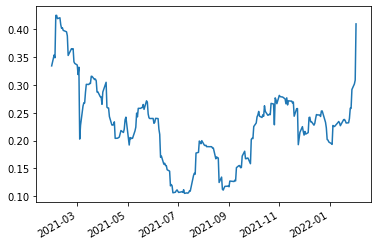

In [11]:
prices['volatility'].plot()

,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,strike-date,type,time,close,volatility


<AxesSubplot:>

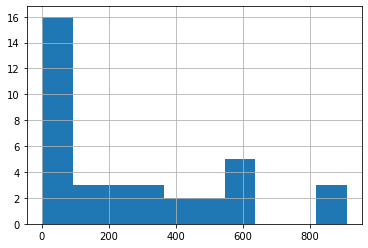

In [68]:
apple['value'] = apple.apply(iv, axis=1)
apple['diff'] = apple['Last Price'] - apple.value
#apple[apple['type']=='call'].plot(x='Strike', y='diff')
apple[apple['Open Interest']<2000]['Open Interest'].hist()

In [23]:
k = 8

strike_pivot = apple2.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero)
strike_cols = strike_pivot.columns
new_apple2 = apple2.reset_index()
new_apple2 = new_apple2.set_index(['type', 'strike-date'])
calls = new_apple2.loc[('call', strike_cols[k])]
calls = calls.reset_index()
#
calls['Last Trade Date'] = pd.to_datetime(calls['Last Trade Date'])
calls['Last Trade Date'] = calls['Last Trade Date'].dt.strftime('%Y-%m-%d')
calls['Last Trade Date'] = pd.to_datetime(calls['Last Trade Date'])
calls = calls.loc[calls['Last Trade Date']==calls['date']]
calls

c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\ipykernel_launcher.py:7: PerformanceWarning: indexing past lexsort depth may impact performance.
  import sys
c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\dateutil\parser\_parser.py:1218: UnknownTimezoneWarning: tzname EST identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  category=UnknownTimezoneWarning)


,type,strike-date,index,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,time,close,volatility
1,call,2021-03-05,32154,2021-01-28,-7.20%,32.90,31.85,-2.7,AAPL210305C00105000,59.38%,34.80,2021-01-28,1.0,105.0,5.0,36.0,137.089996,0.349932
3,call,2021-03-05,32156,2021-01-28,-5.73%,23.75,22.50,-1.58,AAPL210305C00115000,53.35%,26.00,2021-01-28,2.0,115.0,3.0,36.0,137.089996,0.349932
6,call,2021-03-05,32159,2021-01-28,-11.89%,19.50,18.10,-2.79,AAPL210305C00120000,50.98%,20.68,2021-01-28,114.0,120.0,40.0,36.0,137.089996,0.349932
7,call,2021-03-05,32160,2021-01-28,-19.49%,18.65,17.30,-4.78,AAPL210305C00121000,50.24%,19.75,2021-01-28,2.0,121.0,4.0,36.0,137.089996,0.349932
8,call,2021-03-05,32161,2021-01-28,-14.74%,17.90,16.50,-3.25,AAPL210305C00122000,50.24%,18.80,2021-01-28,5.0,122.0,2.0,36.0,137.089996,0.349932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1037,call,2021-03-05,79546,2021-02-24,-,0.02,0.01,0,AAPL210305C00160000,55.47%,0.03,2021-02-24,4845.0,160.0,646.0,9.0,125.349998,0.244821
1038,call,2021-03-05,79547,2021-02-24,-,0.02,0.01,0,AAPL210305C00162500,58.59%,0.01,2021-02-24,729.0,162.5,703.0,9.0,125.349998,0.244821
1039,call,2021-03-05,79548,2021-02-24,-50.00%,0.03,0.01,-0.01,AAPL210305C00165000,63.28%,0.01,2021-02-24,1729.0,165.0,61.0,9.0,125.349998,0.244821
1041,call,2021-03-05,79550,2021-02-24,+100.00%,0.02,0.01,0.01,AAPL210305C00170000,67.19%,0.02,2021-02-24,1127.0,170.0,106.0,9.0,125.349998,0.244821


In [32]:
lowcalls = calls.loc[calls['Strike'] < calls['close']*(1-calls['volatility']*factor)]
lowcalls = lowcalls.loc[lowcalls['time'] == 50]
lowcalls

,type,strike-date,index,date,% Change,Ask,Bid,Change,Contract Name,Implied Volatility,Last Price,Last Trade Date,Open Interest,Strike,Volume,time,close,volatility


In [30]:
factor = 0.5
lowcalls = calls.loc[calls['Strike'] < calls['close']*(1-calls['volatility']*factor)]
lowcalls = lowcalls.loc[lowcalls['time'] == 50]
#lowcalls = lowcalls.loc[lowcalls['time'] == max(lowcalls['time'])]
lowcalls = lowcalls.loc[lowcalls['Last Price'] == min(lowcalls['Last Price'])]
midcalls = calls.loc[calls['Strike'] < calls['close']]
midcalls = midcalls.loc[midcalls['time'] == 50]
#lowcalls = lowcalls.loc[lowcalls['time'] == max(lowcalls['time'])]
midcalls = midcalls.loc[midcalls['Last Price'] == min(midcalls['Last Price'])]
hicalls = calls.loc[calls['Strike'] > calls['close']*(1+calls['volatility']*factor)]
hicalls = hicalls.loc[hicalls['time'] == 50]
#lowcalls = lowcalls.loc[lowcalls['time'] == max(lowcalls['time'])]
hicalls = hicalls.loc[hicalls['Last Price'] == max(hicalls['Last Price'])]

series = apple2.loc[apple2['time'] < 50].set_index('date')
low = series.loc[series['Contract Name']==lowcalls['Contract Name'].values[0]]
low['value'] = low.apply(iv, axis=1)
mid = series.loc[series['Contract Name']==midcalls['Contract Name'].values[0]]
mid['value'] = mid.apply(iv, axis=1)
hi = series.loc[series['Contract Name']==hicalls['Contract Name'].values[0]]
hi['value'] = hi.apply(iv, axis=1)
butterfly2 = low['Last Price'] - 2 * mid['Last Price'] + hi['Last Price']
butterfly = butterfly2.to_frame().reset_index()
value = low['value'] - 2* mid['value'] + hi['value']
value = value.to_frame().reset_index()
butterfly = butterfly.merge(value, on='date')
low = low.reset_index()
hi = hi.reset_index()
butterfly = butterfly.merge(low[['close', 'volatility', 'date', 'time','Strike']], on='date')
butterfly = butterfly.merge(hi[['date','Strike']], on='date')
butterfly['change'] = butterfly['Last Price'].pct_change()
np.mean(butterfly['change'])


ValueError: min() arg is an empty sequence

In [55]:

k = 7

strike_pivot = new_apple.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero)
strike_cols = strike_pivot.columns

new_apple2 = new_apple.reset_index()
new_apple2 = new_apple2.set_index(['type', 'strike-date'])

apple_pivot_call = new_apple2.loc[('call', strike_cols[k])]
strike_pivot = apple_pivot_call.pivot_table(columns="Strike", values="date", aggfunc=np.count_nonzero)
strike_value_cols = strike_pivot.columns
apple_pivot_put = new_apple2.loc[('put', strike_cols[k])]
strike_pivot = apple_pivot_put.pivot_table(columns="Strike", values="date", aggfunc=np.count_nonzero)
strike_value_puts = strike_pivot.columns
#c = new_apple2['c'].mean()
c =132

cols = strike_value_cols[strike_value_cols > c]
puts = strike_value_puts[strike_value_puts < c]

puts = cols
apple_pivot_put = apple_pivot_call

df = apple_pivot_put[apple_pivot_put['Strike'] == puts[0]]
d = puts[0]
df.rename(columns = {'Last Price':str(d)}, inplace = True)
df = df[['date', str(d)]]


for i in range(1,len(puts)):
    df1 = apple_pivot_put[apple_pivot_put['Strike'] == puts[i]]
    df = pd.merge(df, df1[['date', 'Last Price']], on='date')
    df.rename(columns = {'Last Price': str(puts[i])}, inplace = True)

print(c)
print(strike_cols[k])
print(df)
df = df.set_index('date')
plt.figure(); df.plot(); plt.legend(loc='best')


NameError: name 'new_apple' is not defined

In [56]:
k = 14

strike_pivot = new_apple.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero)
strike_cols = strike_pivot.columns

new_apple2 = new_apple.reset_index()
new_apple2 = new_apple2.set_index(['type', 'strike-date'])

NameError: name 'new_apple' is not defined

In [13]:
new_apple2.head()

level_0  index       date % Change   Ask    Bid Change  \
type strike-date                                                           
call 2021-01-08         0      0 2021-01-02   -1.61%  67.9  67.30  -1.11   
     2021-01-08         1      1 2021-01-02   -3.12%  62.9  62.30  -2.04   
     2021-01-08         2      2 2021-01-02        -  57.9  57.30      0   
     2021-01-08         3      3 2021-01-02        -  52.9  52.25      0   
     2021-01-08         4      4 2021-01-02   -2.54%  47.9  47.30  -1.24   

                        Contract Name Implied Volatility  Last Price  \
type strike-date                                                       
call 2021-01-08   AAPL210108C00065000            246.88%       67.64   
     2021-01-08   AAPL210108C00070000            223.44%       63.43   
     2021-01-08   AAPL210108C00075000            201.76%       56.44   
     2021-01-08   AAPL210108C00080000            181.25%       54.62   
     2021-01-08   AAPL210108C00085000            162.11%       47.63   

                         Last Trade Date  Open Interest  Strike  Volume   time  
type strike-date                                                                
call 2021-01-08   2020-12-31 11:25AM EST           38.0    65.0    32.0 6 days  
     2021-01-08    2020-12-31 9:46AM EST           13.0    70.0     5.0 6 days  
     2021-01-08   2020-12-23 11:38AM EST           54.0    75.0    50.0 6 days  
     2021-01-08    2020-12-29 3:54PM EST          167.0    80.0    91.0 6 days  
     2021-01-08    2020-12-31 3:55PM EST           55.0    85.0    65.0 6 days

In [16]:
cols

Float64Index([122.5, 125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0,
              165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0,
              210.0, 215.0, 220.0, 225.0, 230.0, 240.0, 250.0, 260.0, 270.0,
              280.0, 290.0, 300.0, 305.0, 310.0, 315.0, 320.0, 325.0, 330.0,
              335.0, 340.0, 345.0, 350.0, 360.0, 370.0, 380.0, 390.0, 400.0,
              410.0, 420.0, 430.0, 440.0, 450.0, 460.0, 470.0, 480.0, 490.0,
              500.0, 520.0, 540.0, 560.0, 580.0, 600.0, 620.0, 640.0, 660.0,
              680.0, 700.0, 720.0, 740.0, 800.0, 900.0],
             dtype='float64', name='strike')

In [53]:
new_apple6[new_apple6['day']>30].dropna()['condor-change']

45   -0.002066
46   -0.002070
47   -0.002075
48   -0.002079
49   -0.002083
        ...   
25   -0.000909
26   -0.000910
27   -0.000911
28   -0.000912
29   -0.000912
Name: condor-change, Length: 18844, dtype: float64

In [24]:
new_apple[new_apple['time'].dt.days == 60]

,date,iv,last,strike,strike-date,type,time,c


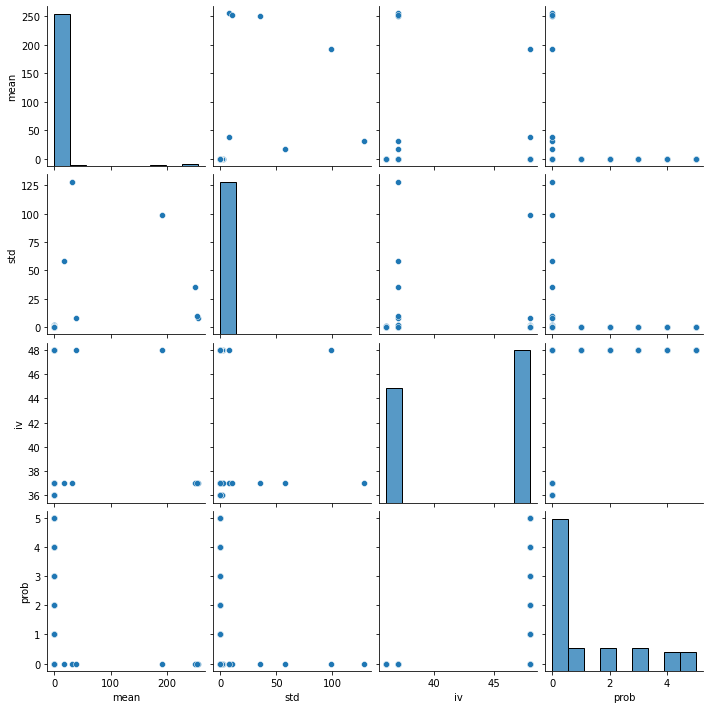

In [71]:
#new_apple5[['prob', 'condor-change', 'start', 'd-strike', 'day']].describe()
sns.pairplot(new_apple6[['mean','std','iv','prob']])
#sns.pairplot(new_apple5[new_apple5['d-strike'] == 3])

In [35]:
start = time.time()
new_apple5 = []
ivol = []

for k in range(13,16):
    new_apple2 = new_apple.reset_index()
    new_apple2 = new_apple2.set_index(['strike-date'])
    print(strike_cols[k])
    new_apple3 = new_apple2.loc[strike_cols[k]]
    
    for day in range(max(new_apple3['time']).days):
    
        new_apple4 = new_apple3[new_apple3['time'].dt.days == day]

        if len(new_apple4) > 0:
            new_apple4 = new_apple4.reset_index()
            iv2 = abs(new_apple4['strike'] - new_apple4['c'])
            iv = new_apple4.loc[iv2.idxmin()]['iv']
            c = new_apple4.loc[iv2.idxmin()]['c']
            date = new_apple4.loc[iv2.idxmin()]['date']
            strike_date = new_apple4.loc[iv2.idxmin()]['strike-date']
            ivol.append([date, iv])

            new_apple2 = new_apple2.reset_index()
            new_apple2 = new_apple2.set_index(['type','strike-date'])
            apple_pivot_call = new_apple2.loc[('Call', strike_cols[k])]
            strike_pivot = apple_pivot_call.pivot_table(columns="strike", values="date", aggfunc=np.count_nonzero)
            strike_value_cols = strike_pivot.columns
            apple_pivot_put = new_apple2.loc[('Put', strike_cols[k])]
            strike_pivot = apple_pivot_put.pivot_table(columns="strike", values="date", aggfunc=np.count_nonzero)
            strike_value_puts = strike_pivot.columns

            cols = strike_value_cols[strike_value_cols > c]

            new_apple2 = new_apple2.reset_index()
            new_apple2 = new_apple2.set_index(['type', 'strike', 'strike-date'])
            deltaStrikes = 3

            for i in range(len(cols)-deltaStrikes):
                minput = abs(strike_value_puts - 2*c + cols[i])
                put = strike_value_puts[minput==min(minput)][0]
                #Calculation for second put (insurance)
                puts = strike_value_puts ==put
                puts2 = np.arange(0,len(puts), 1)
                put2 = strike_value_puts[puts2[puts]-deltaStrikes]

                aCLo = new_apple2.loc[('Call', cols[i], strike_cols[k])].drop_duplicates(subset ="date")[['last', 'date', 'c']]
                aCLo = aCLo.reset_index()
                idx = pd.date_range(min(aCLo['date']), max(aCLo['date']), freq = "D")
                aCLo.index = pd.DatetimeIndex(aCLo.date)
                aCLo = aCLo.reindex(idx,fill_value=None)
                aCLo = aCLo.interpolate(method ='linear', limit_direction ='forward')
                aCLo = aCLo.drop(['type', 'strike-date', 'date'], axis=1)
                aCLo = aCLo.reset_index()
                aCLo.rename(columns = {'last':'priceCLo', 'strike':'strikeCLo', 'index': 'date'}, inplace = True)

                aCHi = new_apple2.loc[('Call', cols[i+deltaStrikes], strike_cols[k])].drop_duplicates(subset ="date")[['last', 'date', 'c']]
                aCHi = aCHi.reset_index()
                idx = pd.date_range(min(aCHi['date']), max(aCHi['date']), freq = "D")
                aCHi.index = pd.DatetimeIndex(aCHi.date)
                aCHi = aCHi.reindex(idx,fill_value=None)
                aCHi = aCHi.interpolate(method ='linear', limit_direction ='forward')
                aCHi = aCHi.drop(['type', 'strike-date', 'date'], axis=1)
                aCHi = aCHi.reset_index()
                aCHi.rename(columns = {'last':'priceCHi', 'strike':'strikeCHi', 'index': 'date'}, inplace = True)

                aPLo = new_apple2.loc[('Put', put2, strike_cols[k])].drop_duplicates(subset ="date")[['last', 'date', 'c']]
                aPLo = aPLo.reset_index()
                idx = pd.date_range(min(aPLo['date']), max(aPLo['date']), freq = "D")
                aPLo.index = pd.DatetimeIndex(aPLo.date)
                aPLo = aPLo.reindex(idx,fill_value=None)
                aPLo = aPLo.interpolate(method ='linear', limit_direction ='forward')
                aPLo = aPLo.drop(['type', 'strike-date', 'date'], axis=1)
                aPLo = aPLo.reset_index()
                aPLo.rename(columns = {'last':'pricePLo', 'strike':'strikePLo', 'index': 'date'}, inplace = True)

                aPHi = new_apple2.loc[('Put', put, strike_cols[k])].drop_duplicates(subset ="date")[['last', 'date', 'c']]
                aPHi = aPHi.reset_index()
                idx = pd.date_range(min(aPHi['date']), max(aPHi['date']), freq = "D")
                aPHi.index = pd.DatetimeIndex(aPHi.date)
                aPHi = aPHi.reindex(idx,fill_value=None)
                aPHi = aPHi.interpolate(method ='linear', limit_direction ='forward')
                aPHi = aPHi.drop(['type', 'strike-date', 'date'], axis=1)
                aPHi = aPHi.reset_index()
                aPHi.rename(columns = {'last':'pricePHi', 'strike':'strikePHi', 'index': 'date'}, inplace = True)

                a = pd.merge(aCLo, aCHi, on=['date', 'c'])
                a = pd.merge(a, aPLo, on=['date', 'c'])
                a = pd.merge(a, aPHi, on=['date', 'c'])
                #a = a.set_index('date')
                a['condor'] = a['priceCLo'] - a['priceCHi'] + a['pricePHi'] - a['pricePLo']
                a['prob'] = (cols[i] - c) / c
                a['strike-date'] = strike_date
                a['condor-change'] = a['condor'].pct_change()
                a = a[a['date'] > date]
                a['start'] = day
                if len(a) >= 5:
                    new_apple5.append(a)

new_apple5 = pd.concat(new_apple5)
new_apple5 = new_apple5.replace([np.inf, -np.inf], np.nan)
ivol = pd.DataFrame(data=ivol, columns=["date", "iv"])
end = time.time()
print(end - start)
    
    

c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\ipykernel_launcher.py:21: PerformanceWarning: indexing past lexsort depth may impact performance.
c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\ipykernel_launcher.py:24: PerformanceWarning: indexing past lexsort depth may impact performance.


In [9]:
new_apple = new_apple.reset_index()
strike_pivot = new_apple.pivot_table(columns="strike-date", values="date", aggfunc=np.count_nonzero)
strike_date_cols = strike_pivot.columns
strike_pivot = new_apple.pivot_table(columns="Strike", values="date", aggfunc=np.count_nonzero)
strike_cols = strike_pivot.columns

In [13]:
new_apple2 = new_apple
new_apple2 = new_apple2.set_index(['type', 'strike-date', 'Strike'])

In [19]:
new_apple2.loc['put', strike_date_cols[19], 220]

c:\userdata\z003rvhr\python\yahoo_graber\grab\lib\site-packages\ipykernel_launcher.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  """Entry point for launching an IPython kernel.


level_0  index       date % Change    Ask     Bid  \
type strike-date Strike                                                      
put  2023-01-20  220.0       298    298 2020-11-19        -    0.0    0.00   
                 220.0       698    698 2020-11-21        -    0.0    0.00   
                 220.0      1093   1093 2020-11-23        -    0.0    0.00   
                 220.0      1493   1493 2020-11-25        -    0.0    0.00   
                 220.0      3128   3128 2020-11-26        -  107.9  106.25   
                 220.0      3947   3947 2020-11-27        -    0.0    0.00   
                 220.0      4342   4342 2020-11-28        -    0.0    0.00   
                 220.0      4737   4737 2020-11-29        -    0.0    0.00   
                 220.0      5028   5028 2020-11-30        -    0.0    0.00   
                 220.0      5319   5319 2020-12-02        -    0.0    0.00   
                 220.0      5714   5714 2020-12-03        -    0.0    0.00   
                 220.0      6109   6109 2020-12-04        -    0.0    0.00   
                 220.0      6400   6400 2020-12-05        -    0.0    0.00   
                 220.0      6691   6691 2020-12-06        -    0.0    0.00   
                 220.0      6982   6982 2020-12-07        -    0.0    0.00   
                 220.0      7273   7273 2020-12-08        -    0.0    0.00   
                 220.0      7780   7780 2020-12-09        -    0.0    0.00   
                 220.0      8071   8071 2020-12-10        -    0.0    0.00   
                 220.0      8362   8362 2020-12-10        -    0.0    0.00   
                 220.0      8653   8653 2020-12-11        -    0.0    0.00   
                 220.0      8944   8944 2020-12-11        -    0.0    0.00   
                 220.0     11861  11861 2020-12-12   +3.48%  103.4  101.35   
                 220.0     14778  14778 2020-12-13   +3.48%  103.4  101.35   
                 220.0     17713  17713 2020-12-15   +2.05%  103.3  101.75   
                 220.0     17908  17908 2020-12-17        -    0.0    0.00   

                        Change        Contract Name Implied Volatility  \
type strike-date Strike                                                  
put  2023-01-20  220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000             34.71%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0       0  AAPL230120P00220000              0.00%   
                 220.0    3.48  AAPL230120P00220000             36.67%   
                 220.0    3.48  AAPL230120P00220000             36.69%   
                 220.0    2.05  AAPL230120P00220000             35.4